In [ ]:
from datasets import Dataset, Features, ClassLabel, Sequence, Value
from transformers import AutoTokenizer
from collections import defaultdict
import copy
import json
import os

# Load the Indic BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base",  use_fast=True)

MAX_LENGTH = 128

# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['words'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100] * len(word_ids)
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != previous_word_idx:
                if word_idx < len(label):
                    label_ids[idx] = label[word_idx]
                else:
                    label_ids[idx] = -100  # Ignore tokens that don't have a corresponding label
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Function to gather data from nested JSON files
def gather_data(directory):
    all_data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                path = os.path.join(root, file)
                with open(path, 'r', encoding='utf-8') as infile:
                    data = json.load(infile)
                    all_data.extend(data)
    return all_data

# Load data from the specified directories
gold_standard_directory = 'Inception_files/final_documents_clubbed_with_gold_std_ner_and_mask_ids_in_BIO_new/gold_standard'
annotator1_directory = 'Inception_files/final_documents_clubbed_with_gold_std_ner_and_mask_ids_in_BIO_new/annotator_1'
annotator2_directory = 'Inception_files/final_documents_clubbed_with_gold_std_ner_and_mask_ids_in_BIO_new/annotator_2'

gold = gather_data(gold_standard_directory)
annotator1 = gather_data(annotator1_directory)
annotator2 = gather_data(annotator2_directory)

# Combine annotator data
combined_annotator_data = annotator1 + annotator2 + gold

# Initialize a dictionary to store invalid labels and their corresponding words
invalid_label_words = defaultdict(list)

# Function to combine NER and Mask IDs into a single label
def combine_labels(data):
    for item in data:
        combined_labels = []
        for word, ner, mask in zip(item['words'], item['ner'], item['mask_ids']):
            if ner == 'O' and mask == 'O':
                combined_labels.append('O')
            elif ner == 'O' and mask != 'O':
                invalid_label = f"{ner}-{mask}"
                invalid_label_words[invalid_label].append(word)
                continue
            elif ner != 'O' and mask == 'O':
                invalid_label = f"{ner}-{mask}"
                invalid_label_words[invalid_label].append(word)
                continue
            else:
                if mask == "I-mask" or mask == "B-mask":
                    combined_label = f"{ner}-mask"
                else:
                    combined_label = f"{ner}-nomask"
                combined_labels.append(combined_label)
        item['combined_labels'] = combined_labels
    return data

# Combine labels for all datasets
combined_annotator_data = combine_labels(copy.deepcopy(combined_annotator_data))

# Extract unique combined labels from the dataset
unique_combined_labels = sorted(set(label for item in combined_annotator_data for label in item['combined_labels']))

# Create a ClassLabel feature for combined labels
combined_label_feature = ClassLabel(names=unique_combined_labels)

# Convert the combined labels to integers and create the id_to_label mapping
id_to_label = {index: label for index, label in enumerate(unique_combined_labels)}
label_to_id = {label: index for index, label in enumerate(unique_combined_labels)}

# Convert the combined labels to integers using the label_to_id mapping
for item in combined_annotator_data:
    item['labels'] = [label_to_id[label] for label in item['combined_labels']]

# Define features for the dataset
features = Features({
    'words': Sequence(feature=Value(dtype='string', id=None), length=-1),
    'labels': Sequence(feature=combined_label_feature, length=-1)
})

# Create a Dataset for the combined annotator data
combined_dataset = Dataset.from_dict({
    'words': [item['words'] for item in combined_annotator_data],
    'labels': [item['labels'] for item in combined_annotator_data]
}, features=features)

# Tokenize the combined dataset
tokenized_combined_dataset = combined_dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 7952/7952 [00:00<00:00, 12276.27 examples/s]


In [ ]:
import os
import json
import numpy as np
from datasets import Dataset, Features, ClassLabel, Sequence, Value, load_metric
from sklearn.model_selection import KFold
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification, EarlyStoppingCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score
from collections import defaultdict
import evaluate



# Define the model
model_checkpoint = "xlm-roberta-base"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(unique_combined_labels))

# Move model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Load the seqeval metric
metric = evaluate.load("seqeval", trust_remote_code=True)

# Global storage for true and predicted labels
all_true_labels = []
all_pred_labels = []
all_texts = []

# Compute metrics function
def compute_metrics(p):
    global all_true_labels, all_pred_labels
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id_to_label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten the list of lists for metric calculation
    flat_true_labels = [label for sublist in true_labels for label in sublist]
    flat_pred_labels = [label for sublist in true_predictions for label in sublist]

    # Compute precision, recall, f1-score for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        flat_true_labels, flat_pred_labels, labels=list(id_to_label.values()), zero_division=0)

    # Compute macro F1 score
    macro_f1 = f1_score(flat_true_labels, flat_pred_labels, average='macro', labels=list(id_to_label.values()), zero_division=0)

    # Compute accuracy
    accuracy = accuracy_score(flat_true_labels, flat_pred_labels)

    # Store for confusion matrix computation and output logging
    all_true_labels.extend(true_labels)
    all_pred_labels.extend(true_predictions)

    # Prepare results
    results = {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
    }

    for i, label in enumerate(list(id_to_label.values())):
        results[f"precision_{label}"] = precision[i]
        results[f"recall_{label}"] = recall[i]
        results[f"f1_{label}"] = f1[i]
        results[f"support_{label}"] = support[i]  # Add support to understand class distribution

    return results

# Setup k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []

# Hyperparameters
best_learning_rate= 1.3348323018961492e-05
best_train_epochs= 5
best_warmup_steps= 52

# Create a directory to store the results
os.makedirs('Inception_files/XLM-R_final', exist_ok=True)

# Training loop for cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(tokenized_combined_dataset)):
    print(f"Training fold {fold+1}/{k}")
    train_subset = tokenized_combined_dataset.select(train_idx)
    val_subset = tokenized_combined_dataset.select(val_idx)

    # Define the training arguments with early stopping
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',
        eval_strategy='epoch',  # Evaluate at the end of each epoch
        save_strategy='epoch',        # Save at the end of each epoch to align with evaluation
        learning_rate=best_learning_rate,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=best_train_epochs,
        weight_decay=0.01,
        warmup_steps=best_warmup_steps,
        load_best_model_at_end=True,  # Ensure the best model is loaded at the end
        metric_for_best_model='eval_loss',
        logging_dir=f'./logs_fold_{fold}',
        logging_steps=10,
        report_to='none'
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=val_subset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]  # Add the early stopping callback
    )

    # Train the model
    trainer.train()

    # Save the model after each fold
    trainer.save_model(f'Inception_files/XLM-R_final/saved_models_XLM-R/model_fold_{fold}')
    eval_results = trainer.evaluate()

    # Store the results
    fold_results.append(eval_results)

# Summarize the results across all folds
metric_accumulator = defaultdict(list)

for result in fold_results:
    for key in result.keys():
        metric_accumulator[key].append(result[key])

average_metrics = {key: np.mean(values) for key, values in metric_accumulator.items()}

print("Average metrics across all folds:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

with open("Inception_files/XLM-R_final/detailed_metrics_XLM-R.json", "w") as f:
    json.dump(average_metrics, f, indent=4)



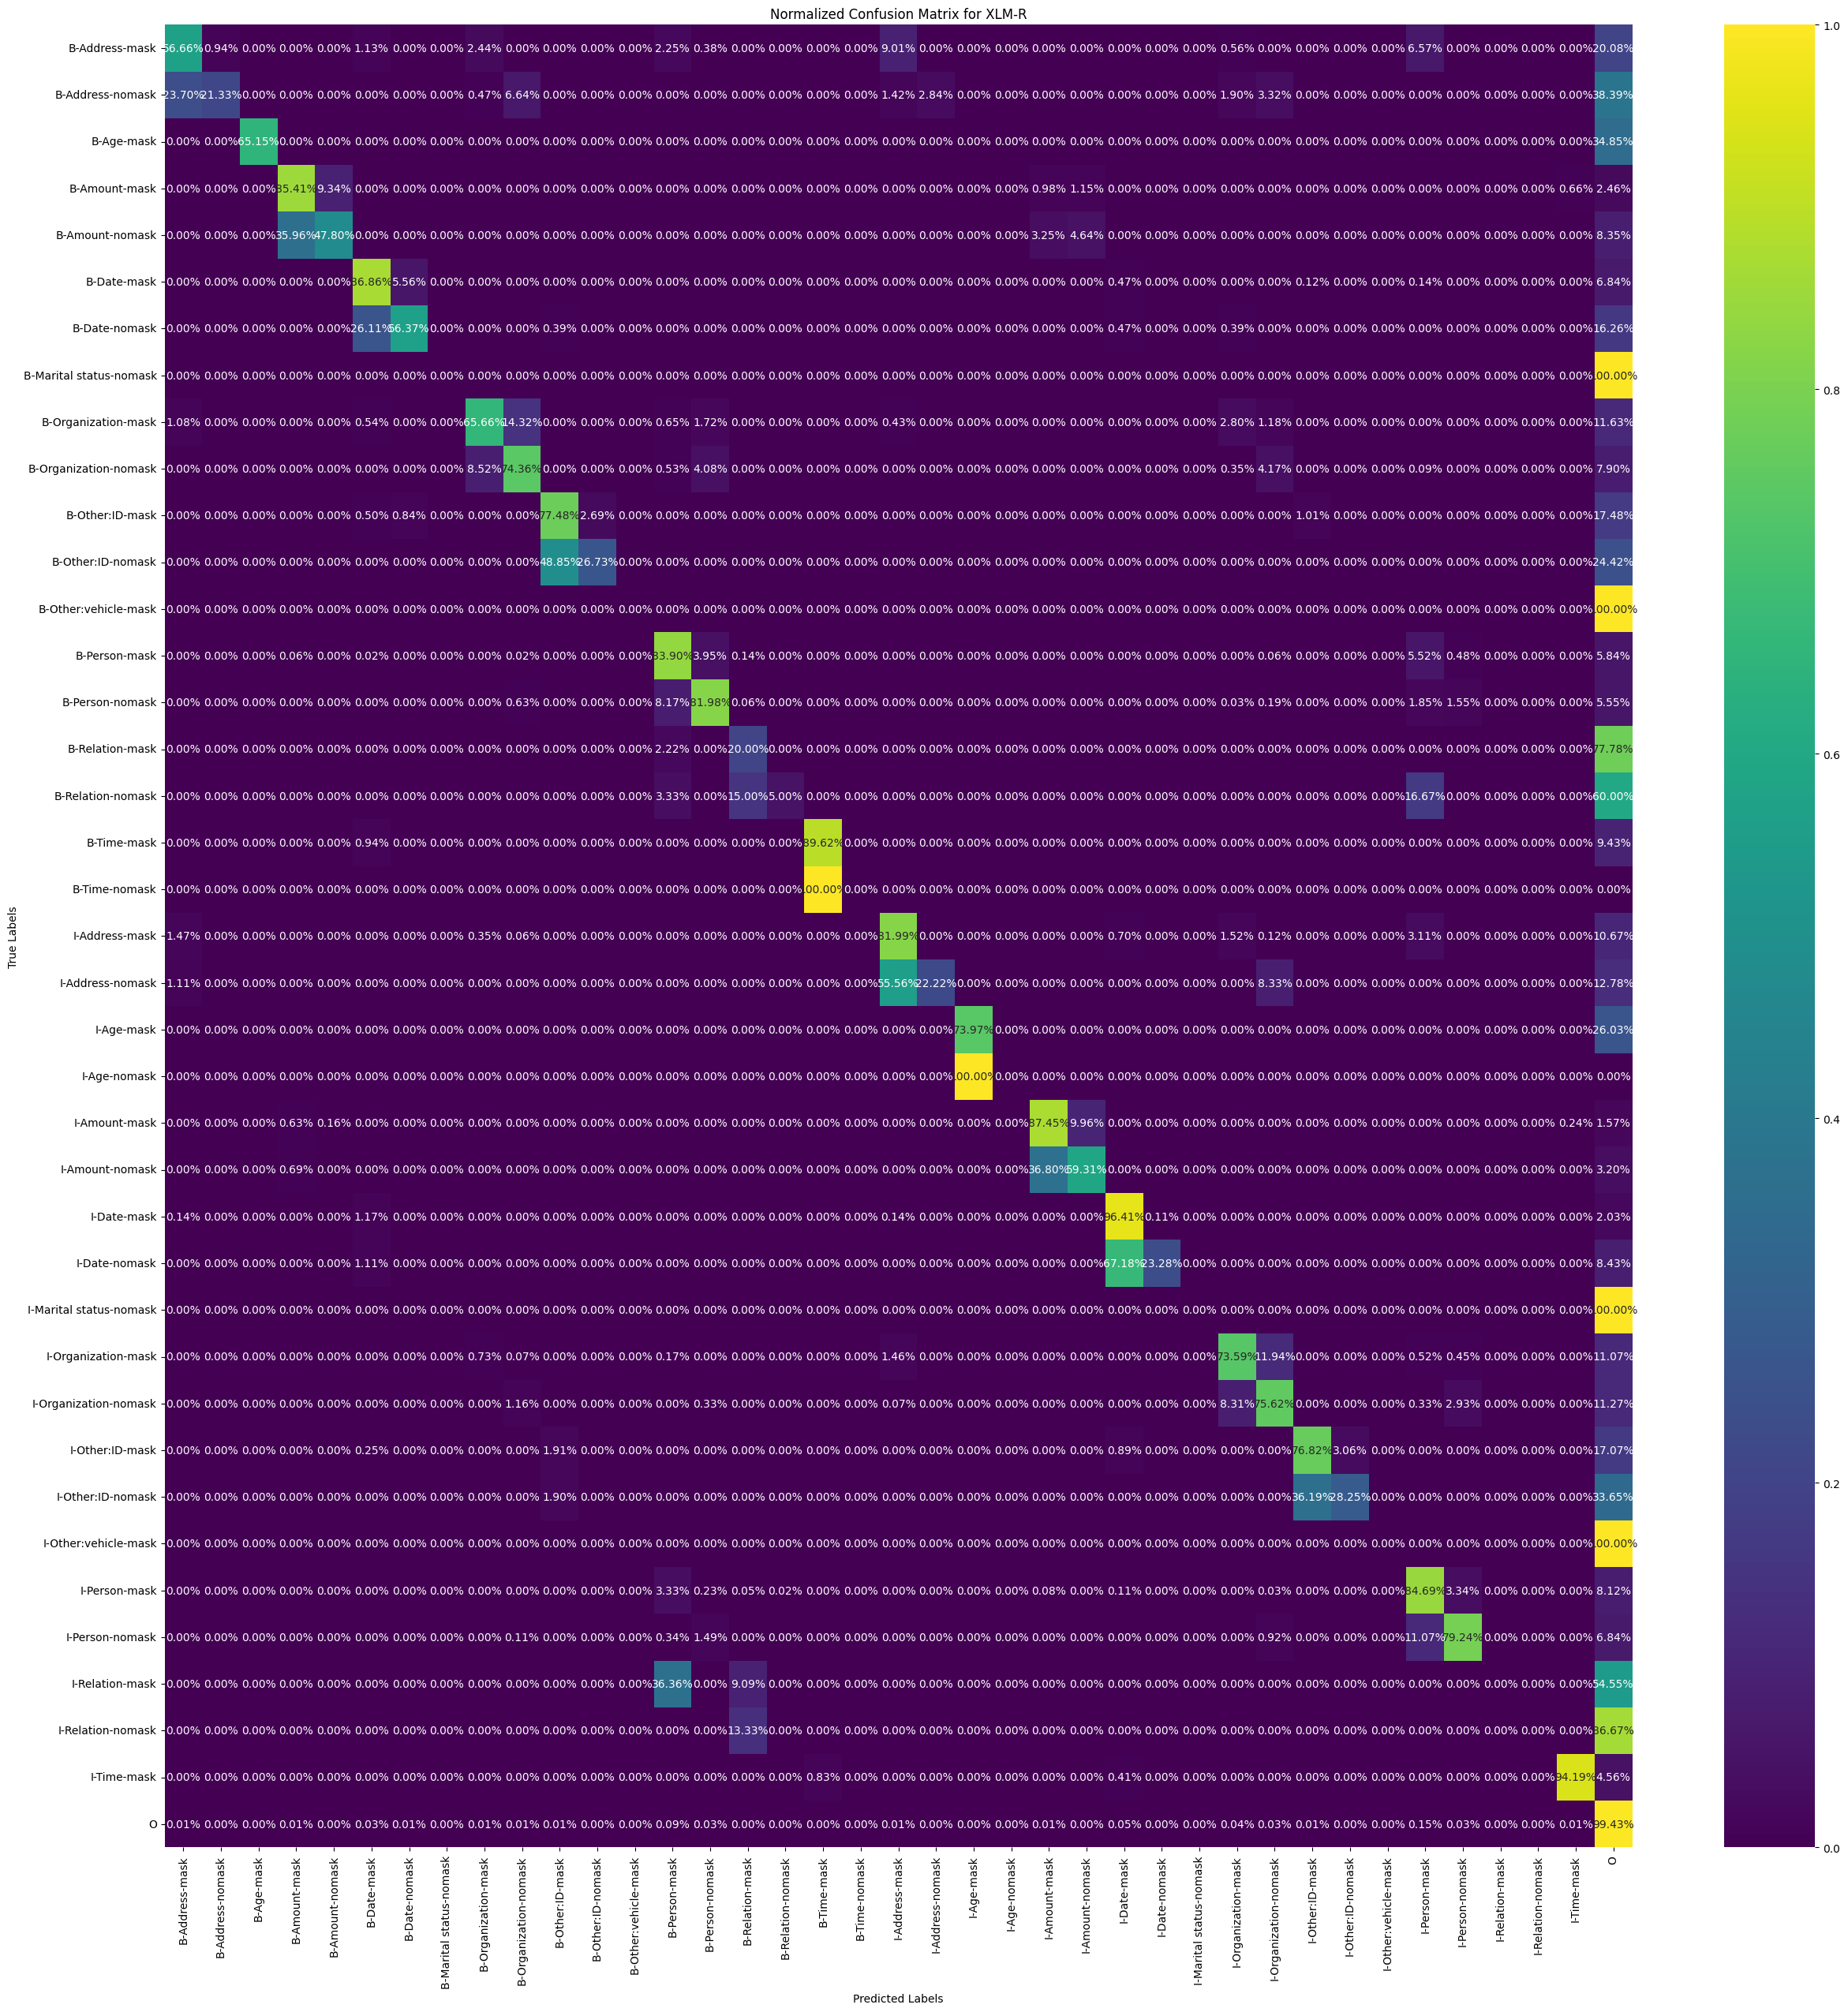

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, label_list, output_path):
    # Flatten the list of lists to get all labels
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_pred_labels = [item for sublist in pred_labels for item in sublist]

    # Compute the confusion matrix
    cm = confusion_matrix(flat_true_labels, flat_pred_labels, labels=label_list)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='viridis', xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix for XLM-R')
    plt.savefig(output_path)
    plt.show()

# Plot the confusion matrix for all collected true and predicted labels
plot_confusion_matrix(all_true_labels, all_pred_labels, list(id_to_label.values()), "Inception_files/XLM-R_final/confusion_matrix_XLM-R.png")


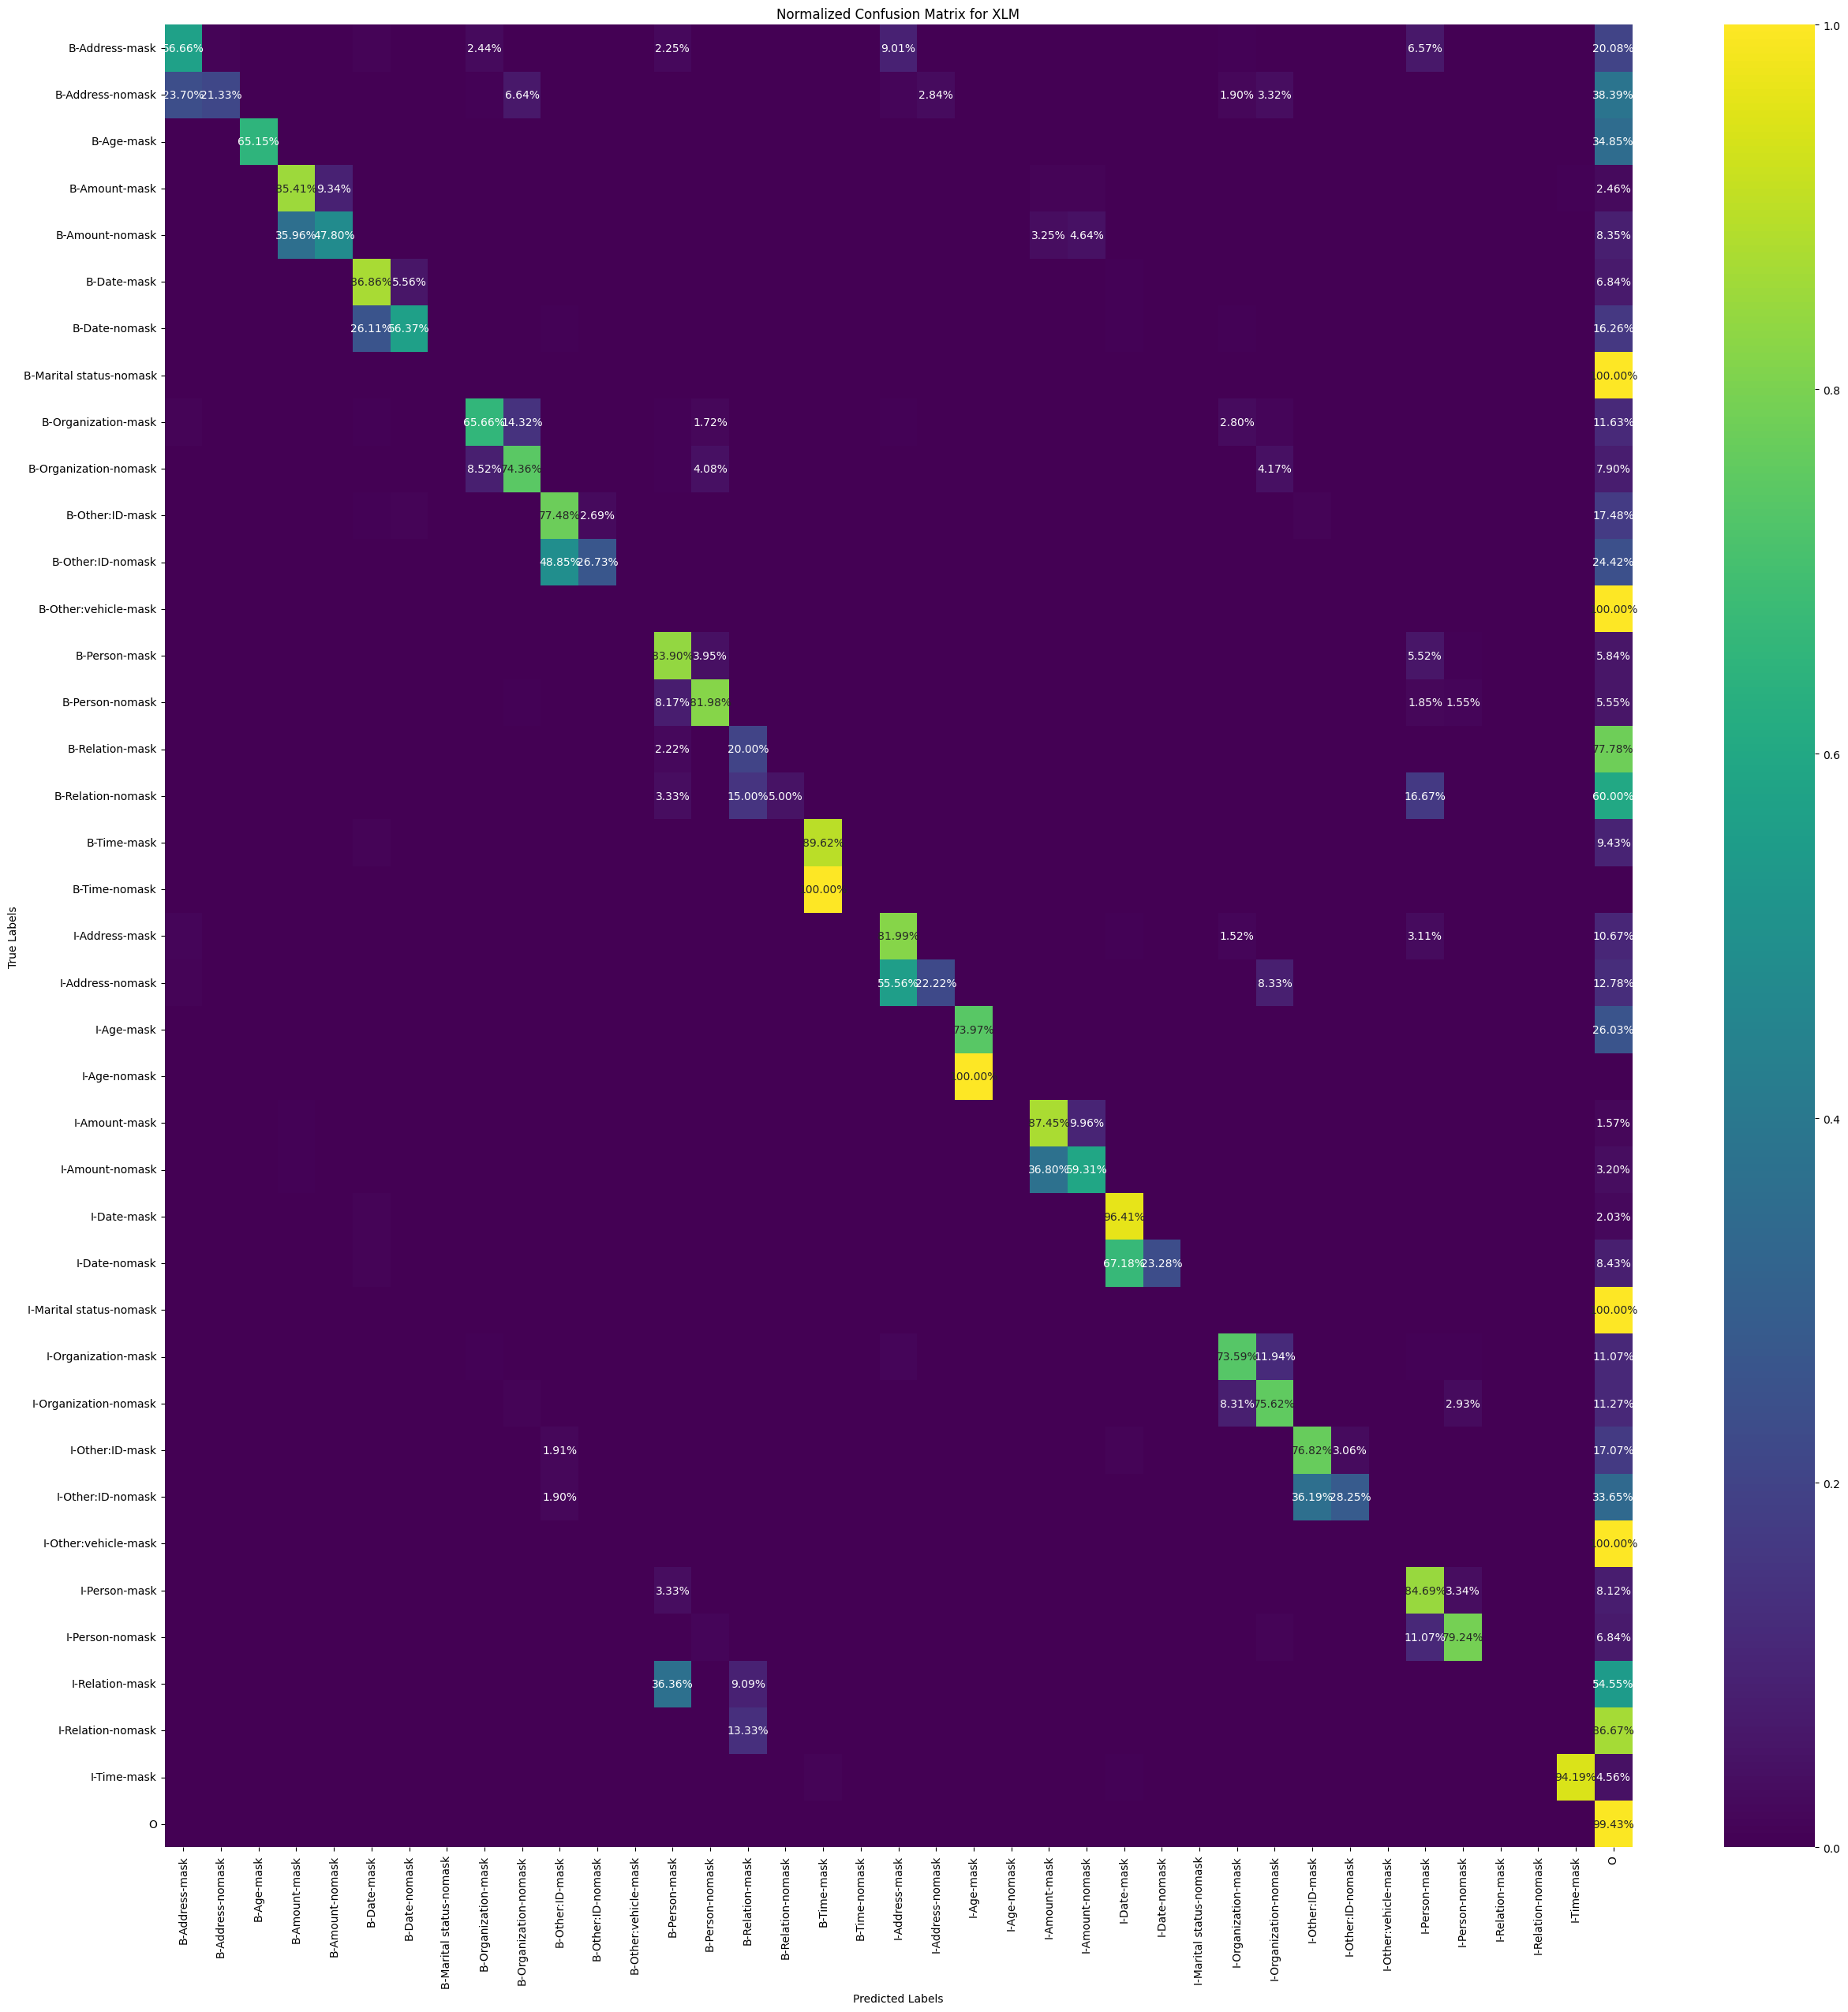

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to plot confusion matrix with custom annotations
def plot_confusion_matrix(true_labels, pred_labels, label_list, output_path, threshold=1.5):
    # Flatten the list of lists to get all labels
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_pred_labels = [item for sublist in pred_labels for item in sublist]

    # Compute the confusion matrix
    cm = confusion_matrix(flat_true_labels, flat_pred_labels, labels=label_list)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Custom annotation function
    def annotate(values, threshold):
        return [f"{value:.2%}" if value >= threshold / 100 else "" for value in values]  # Display values greater than threshold

    # Create custom annotations
    annotations = np.array([annotate(row, threshold) for row in cm_normalized])

    # Plot the confusion matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='viridis', xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix for XLM')
    plt.savefig(output_path)
    plt.show()

# Plot the confusion matrix for all collected true and predicted labels
plot_confusion_matrix(all_true_labels, all_pred_labels, list(id_to_label.values()), "Inception_files/XLM-R_final/confusion_matrix_XLM-R_noZeros.png")
